# 0 Imports

In [1]:
import os, warnings, re, shutil
from datetime import datetime
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, hamming_loss, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from skmultilearn.model_selection import iterative_train_test_split

from bs4 import BeautifulSoup as bs
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
# nltk.download()
from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import bert
from transformers import TFBertModel, BertConfig, BertTokenizerFast

# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

import scripts

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

print("-----------------------------------------")
if tf.test.gpu_device_name():
    print(f"GPU used: {tf.test.gpu_device_name()}")
else:
    print(f"GPU not used")
print("-----------------------------------------")

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

/home/alex/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


-----------------------------------------
GPU used: /device:GPU:0
-----------------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18227616092894452371
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3460038656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9991769021789372648
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-02-13 17:27:10.632271: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 17:27:10.648928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:27:10.679088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:27:10.679389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

***
# 1 Config

In [2]:
config = {
    "raw_preprocessing": False,
    "preprocessing": False,
    "baseline": False,
    "bert_base": False,
    "bert_se": False
}

***
# 2 Preprocessing

## 2.0 Utils

In [3]:
def preproc_raw_data_body(cell):
    soup = bs(cell, "html.parser")

    script_tags = soup.find_all("script")
    for script_tag in script_tags:
        script_tag.extract()

    code_tags = soup.find_all("code")
    for code_tag in code_tags:
        code_tag.extract()

    preproc_cell = soup.get_text()
    preproc_cell = preproc_cell.replace(',', ' ')

    return preproc_cell

In [4]:
def tags_to_list(cell):
    return [tag for tag in re.split(r'[<>]', cell) if tag]

In [5]:
def lower(cell):
    return cell.lower()

In [6]:
def tokenize(*texts):
    tokens = []
    for text in texts:
        # https://regex101.com/
        tokenizer = nltk.RegexpTokenizer(r'\.?[a-z#]+')
        tokens_temp = tokenizer.tokenize(text)
        tokens += [re.sub("(.)\\1{3,}", "\\1", token) for token in tokens_temp]
    return tokens

In [7]:
def remove_stop_words(cell):
    return [word for word in cell if word not in stop_words]

In [8]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

In [9]:
def tag_pos(cell):
    treebank_tags = pos_tag(cell)
    pos = [(tag[0], get_wordnet_pos(tag[1])) for tag in treebank_tags]
    return pos

In [10]:
def lemmatize(cell, with_pos=False):
    lemmatizer = WordNetLemmatizer()
    if not with_pos:
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in cell]
    else:
        lemmatized_tokens = [lemmatizer.lemmatize(pair[0], pos=pair[1]) for pair in cell]
    return lemmatized_tokens

In [11]:
def stemmize(cell):
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in cell]
    return stemmed_tokens

## 2.1 Loading raw data

In [12]:
if config["raw_preprocessing"]:

    raw_data_body = pd.read_csv("data/raw_data_body.csv")
    raw_data_body.shape

## 2.2 Parse html

In [13]:
if config["raw_preprocessing"]:

    raw_data_body["Body"] = raw_data_body.apply(lambda row: preproc_raw_data_body(row.Body), axis=1)

## 2.3 Merge body with rest

In [14]:
display = None

if config["raw_preprocessing"]:

    raw_data_rest = pd.read_csv("data/raw_data_id_title_tags.csv")
    raw_data = raw_data_rest.join(raw_data_body)
    raw_data = raw_data.set_index("Id").reindex(["Title", "Body", "Tags"], axis="columns")
    raw_data["Sentence_Pristine"] = raw_data.apply(lambda row: row["Title"] + " " + row["Body"], axis="columns")
    display = raw_data.head()

display

## 2.4 Tags to list

In [15]:
display = None

if config["raw_preprocessing"]:

    raw_data["Tags"] = raw_data.apply(lambda row: tags_to_list(row["Tags"]), axis="columns")
    display = raw_data[["Tags"]].head()

display

## 2.5 Lowering

In [16]:
display = None

if config["raw_preprocessing"]:

    raw_data["Sentence_Pristine"] = raw_data.apply(lambda row: lower(row["Sentence_Pristine"]), axis="columns")
    display = raw_data[["Sentence_Pristine"]].head()

display

## 2.6 Save raw preprocessed data

In [17]:
if config["raw_preprocessing"]:
    
    raw_data.drop(columns=["Title", "Body"], inplace=True)
    raw_data.to_csv("data/raw_data.csv")

## 2.7 Load raw preprocessed data

In [18]:
if config["preprocessing"]:
    
    data = pd.read_csv("data/raw_data.csv", index_col="Id")

## 2.8 Tokenize

In [19]:
display = None

if config["preprocessing"]:

    data["Tokens"] = data.apply(lambda row: tokenize(row["Sentence_Pristine"]), axis="columns")
    display = data[["Sentence_Pristine", "Tokens"]].head()

display

## 2.9 StopWords deletion

In [20]:
display = None

if config["preprocessing"]:

    stop_words = stopwords.words("english")
    data["Tokens"] = data.apply(lambda row: remove_stop_words(row["Tokens"]), axis="columns")
    display = data[["Sentence_Pristine", "Tokens"]].head()

display

## 2.10 POS - Part-Of-Speech

In [21]:
display = None

if config["preprocessing"]:

    data["POS"] = data.apply(lambda row: tag_pos(row["Tokens"]), axis="columns")
    display = data[["Tokens", "POS"]].head()

display

## 2.11 Lemmatize

In [22]:
display = None

if config["preprocessing"]:

    data["Lemmatized"] = data.apply(lambda row: lemmatize(row["POS"], with_pos=True), axis="columns")
    display = data[["Tokens", "Lemmatized"]].head()

display

## 2.12 Stemmize

In [23]:
display = None

if config["preprocessing"]:

    data["LemmaAndStem"] = data.apply(lambda row: stemmize(row["Tokens"]), axis="columns")
    display = data[["Tokens", "LemmaAndStem"]].head()

display

## 2.13 Generating sentence

In [24]:
display = None

if config["preprocessing"]:

    data["Sentence"] = data.apply(lambda row: " ".join([str(item) for item in row["LemmaAndStem"]]), axis="columns")
    display = data[["LemmaAndStem", "Sentence"]].head()

display

## 2.14 Saving data

In [25]:
display = None

if config["preprocessing"]:

    data.to_csv("data/data_cleaned.csv", index_label="Id")
    display = data.head()

display

***
# 3 Data preparation

## 3.0 Utils

In [26]:
def bow(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=max_features, max_df=max_df, min_df=min_df)
    matrix = vectorizer.fit_transform(dataset)

    data_dense = matrix.todense()
    print(f"Sparcity: {((data_dense > 0).sum() / data_dense.size)*100:.4}%")

    vocab = vectorizer.get_feature_names_out()

    matrix = matrix.toarray()
    bag = pd.DataFrame(data=matrix, columns=vocab)
    return bag, vectorizer

In [27]:
def tfidf(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = TfidfVectorizer(tokenizer=None, stop_words=None, max_features=max_features, min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(dataset).toarray()
    vocab = vectorizer.get_feature_names_out()
    tfidf = pd.DataFrame(data=matrix, columns=vocab)
    return tfidf, vectorizer

## 3.1 Loading

In [28]:
data = pd.read_csv("data/data_cleaned.csv", index_col="Id")
data = data.reset_index()
data = data.iloc[:, 1:]

data["Tags"] = data["Tags"].apply(eval)

data.head()

,Tags,Sentence_Pristine,Tokens,POS,Lemmatized,LemmaAndStem,Sentence
0,"[c#, floating-point, type-conversion, double, ...",how to convert a decimal to a double in c#? i ...,"['convert', 'decimal', 'double', 'c#', 'want',...","[('convert', 'n'), ('decimal', 'n'), ('double'...","['convert', 'decimal', 'double', 'c#', 'want',...","['convert', 'decim', 'doubl', 'c#', 'want', 'u...",convert decim doubl c# want use chang opac cod...
1,"[html, css, internet-explorer-7]",why did the width collapse in the percentage w...,"['width', 'collapse', 'percentage', 'width', '...","[('width', 'n'), ('collapse', 'n'), ('percenta...","['width', 'collapse', 'percentage', 'width', '...","['width', 'collaps', 'percentag', 'width', 'ch...",width collaps percentag width child element ab...
2,"[c#, .net, datetime]",how do i calculate someone's age based on a da...,"['calculate', 'someone', 'age', 'based', 'date...","[('calculate', 'n'), ('someone', 'n'), ('age',...","['calculate', 'someone', 'age', 'base', 'datet...","['calcul', 'someon', 'age', 'base', 'datetim',...",calcul someon age base datetim type birthday g...
3,"[c#, datetime, time, datediff, relative-time-s...",calculate relative time in c# given a specific...,"['calculate', 'relative', 'time', 'c#', 'given...","[('calculate', 'v'), ('relative', 'a'), ('time...","['calculate', 'relative', 'time', 'c#', 'give'...","['calcul', 'relat', 'time', 'c#', 'given', 'sp...",calcul relat time c# given specif valu display...
4,"[html, browser, timezone, user-agent, timezone...",determine a user's timezone is there a standar...,"['determine', 'user', 'timezone', 'standard', ...","[('determine', 'v'), ('user', 'n'), ('timezone...","['determine', 'user', 'timezone', 'standard', ...","['determin', 'user', 'timezon', 'standard', 'w...",determin user timezon standard way web server ...


## 3.2 Tags

In [29]:
data[["Tags"]].head()

,Tags
0,"[c#, floating-point, type-conversion, double, ..."
1,"[html, css, internet-explorer-7]"
2,"[c#, .net, datetime]"
3,"[c#, datetime, time, datediff, relative-time-s..."
4,"[html, browser, timezone, user-agent, timezone..."


In [30]:
data.Tags.values

array([list(['c#', 'floating-point', 'type-conversion', 'double', 'decimal']),
       list(['html', 'css', 'internet-explorer-7']),
       list(['c#', '.net', 'datetime']), ...,
       list(['css', 'xhtml', 'refactoring']),
       list(['python', 'class', 'anonymous-class']),
       list(['c', 'linux', 'file', 'io', 'std'])], dtype=object)

In [31]:
tags = []
for row in data.Tags.values:
    tags += row
tags_df = pd.DataFrame(data=tags, columns=["Tag"]).value_counts().reset_index()
tags_df.columns = ["Tag", "Count"]

In [32]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9252 entries, 0 to 9251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     9252 non-null   object
 1   Count   9252 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 144.7+ KB


In [33]:
tags_df.head()

,Tag,Count
0,c#,6448
1,.net,5174
2,java,3758
3,asp.net,3261
4,c++,2691


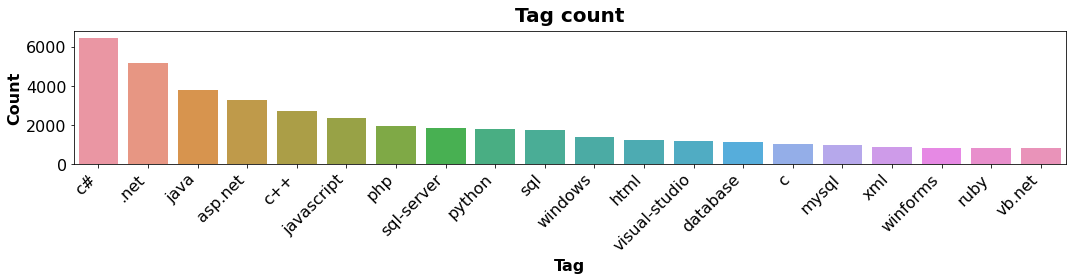

In [34]:
plt.figure(figsize=(15, 4))

sns.barplot(data=tags_df.iloc[:20], x="Tag", y="Count")

plt.title("Tag count", size=20)
plt.xlabel("Tag", size=16)
plt.ylabel("Count", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

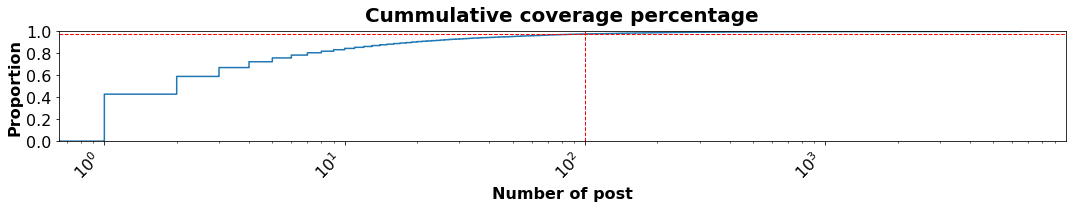

In [35]:
plt.figure(figsize=(15, 3))

ax = sns.ecdfplot(data=tags_df, x="Count", log_scale=True)

plt.axhline(0.98, linestyle="--", linewidth=1, color="r")
plt.axvline(100, linestyle="--", linewidth=1, color="r")

plt.title("Cummulative coverage percentage", size=20)
plt.xlabel("Number of post", size=16)
plt.ylabel("Proportion", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [36]:
tags_df = tags_df[:100]
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     100 non-null    object
 1   Count   100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


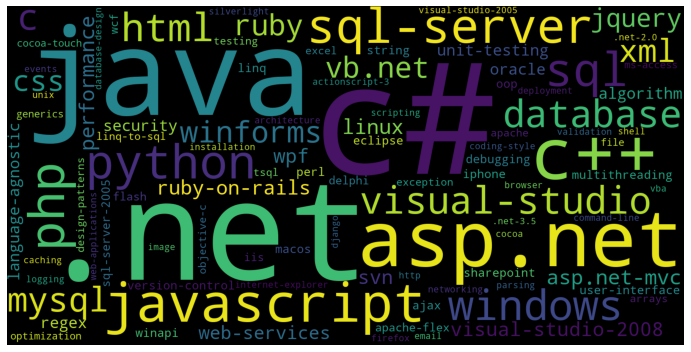

In [37]:
word_frequencies = dict(zip(tags_df.Tag, tags_df.Count))
wordcloud = WordCloud(background_color="black", width=1600, height=800).generate_from_frequencies(word_frequencies)

fig = plt.figure(figsize=(15, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [38]:
tags = tags_df.Tag.tolist()

In [39]:
tags[:20]

['c#',
 '.net',
 'java',
 'asp.net',
 'c++',
 'javascript',
 'php',
 'sql-server',
 'python',
 'sql',
 'windows',
 'html',
 'visual-studio',
 'database',
 'c',
 'mysql',
 'xml',
 'winforms',
 'ruby',
 'vb.net']

In [40]:
def find_or_remove(cell, word_list):
    return [word for word in cell if word in word_list]

In [41]:
data["Tags_Reduced"] = data.apply(lambda row: find_or_remove(row["Tags"], tags),axis="columns")

In [42]:
data["Tags_Reduced"].isna().any()

False

In [43]:
data["Tags_Reduced"].head()

0               [c#]
1        [html, css]
2         [c#, .net]
3               [c#]
4    [html, browser]
Name: Tags_Reduced, dtype: object

***
# 4 Baseline

## 4.0 Utils

In [44]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn
#
def latent_dirichlet_allocation_tuning(dataset: pd.DataFrame, param_grid: dict):
    data_bow, vectorizer = bow(dataset, min_df=.005)
    feature_names = data_bow.columns

    lda = LatentDirichletAllocation()
    gs = GridSearchCV(lda, param_grid)
    gs.fit(data_bow)

    lda_model = gs.best_estimator_
    lda_output = lda_model.transform(data_bow)
    topic_names = ["Topic"+str(i) for i in range(lda_model.n_components)]

    lda_output_dataframe = pd.DataFrame(np.round(lda_output, 2), columns=topic_names)

    return gs, feature_names, data_bow, vectorizer, lda_output_dataframe

In [45]:
def get_dominant_topic(lda_model, data_bow, dataset_row_nb):
    lda_output = lda_model.transform(data_bow)

    topic_names = ["Topic"+str(i) for i in range(lda_model.n_components)]
    doc_names = ["Doc"+str(i) for i in range(dataset_row_nb)]

    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

    dominant_topics = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["Dominant_Topic"] = dominant_topics

    return df_document_topic

In [46]:
def topic_distribution(dominant_topic_df):
    distribution = dominant_topic_df["Dominant_Topic"].value_counts().reset_index()
    distribution.columns = ["Dominant_Topic", "Count"]

    plt.figure(figsize=(15, 4))

    sns.countplot(data=dominant_topic_df, x="Dominant_Topic")

    plt.title("Tag count", size=20)
    plt.xlabel("Tag", size=16)
    plt.ylabel("Count", size=16)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

    return distribution

In [47]:
def topic_words(lda_model, feature_names, n_words=20):
    keywords = np.array(feature_names)
    topic_keywords = []
    for topic_weight in lda_model.components_:
        topic_keyword_locs = (-topic_weight).argsort()[:n_words]
        topic_keywords.append(feature_names.take(topic_keyword_locs))
    
    topic_keywords_df = pd.DataFrame(data=topic_keywords)
    topic_keywords_df.columns = ["Word"+str(i) for i in range(topic_keywords_df.shape[1])]
    topic_keywords_df.index = ["Topic"+str(i) for i in range(topic_keywords_df.shape[0])]
    return topic_keywords_df

In [48]:
def make_prediction(lda_model, sentence, vectorizer, topic_keywords_dataset):
    sentence = scripts.preprocess_sentence(sentence)
    data_bow = vectorizer.transform([sentence])
    topic_probability_score = lda_model.transform(data_bow)
    topic = topic_keywords_dataset.iloc[np.argmax(topic_probability_score), :]
    topic_name = topic.name
    topic_words = topic.values.tolist()
    return topic_name, topic_words, topic_probability_score

In [49]:
def classifier_tuning_post_lda(dataset_X: pd.DataFrame, dataset_y: pd.DataFrame, meta_model, model, param_grid: dict, scoring: str = "f1_micro"):
    start = datetime.now()

    # target multi label binarizer
    multi_label_binarizer = MultiLabelBinarizer()
    y = multi_label_binarizer.fit_transform(dataset_y)

    feature_names = dataset_X.columns
    classes = multi_label_binarizer.classes_

    X_train, X_test, y_train, y_test = train_test_split(dataset_X, y, test_size = 0.33, random_state = 1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # multioutput or onevsrest ...
    meta_model.fit(X_train, y_train)

    # gridsearch tuning/fitting
    gs = GridSearchCV(meta_model, param_grid, scoring=scoring, refit=True)
    gs.fit(X_train, y_train)

    # advanced evaluation
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"classifier_tuning > Time taken to run this cell : {datetime.now() - start} \n")

    return gs, classes, y_test, y_pred

In [50]:
def evaluate(gs, classes, y_test, y_pred):
    start = datetime.now()

    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Hamming loss ", hamming_loss(y_test, y_pred))

    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

    print(f"evaluate > Time taken to run this cell : {datetime.now() - start}\n")

***
## 4.1 Latent Dirichlet Allocation

In [51]:
if config["baseline"]:

    param_grid = {
        "n_components": [10],
        "learning_decay": [.7],
        "random_state": [0],
        "n_jobs": [10]
    }

    gs, feature_names, data_bow, vectorizer, lda_output_dataframe = latent_dirichlet_allocation_tuning(data["Sentence"], param_grid)

In [52]:
if config["baseline"]:

    print(f"Log likelihood: {gs.best_estimator_.score(data_bow)}")
    print(f"Perplexity: {gs.best_estimator_.perplexity(data_bow)}")
    print(f"Best params: {gs.best_params_}")

In [53]:
if config["baseline"]:

    dominant_topic_df = get_dominant_topic(gs.best_estimator_, data_bow, data.shape[0])
    dominant_topic_df.head()

In [54]:
if config["baseline"]:

    topic_distribution(dominant_topic_df)

In [55]:
if config["baseline"]:

    topic_keywords_df = pd.DataFrame(data=gs.best_estimator_.components_, columns=feature_names, index=dominant_topic_df.columns[:-1])
    topic_keywords_df.info()    

In [56]:
display = None

if config["baseline"]:

    display = topic_keywords_df.iloc[:, :20]

display

In [57]:
display = None

if config["baseline"]:

    topic_keywords_dataset = topic_words(lda_model=gs.best_estimator_, feature_names=feature_names, n_words=20)
    display = topic_keywords_dataset

display

In [58]:
if config["baseline"]:

    param_grid = {
        "estimator__solver": ["liblinear"],
        "estimator__penalty": ["l1"],
        "estimator__random_state": [0],
    }

    model = LogisticRegression()
    meta_model = OneVsRestClassifier(model)
    gs, classes, y_test, y_pred = classifier_tuning_post_lda(lda_output_dataframe, data["Tags_Reduced"], meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

***
## 4.2 Results

<img src="records/lda_results_metrics.png" style="background-color:white">

<img src="records/lda_results_topic_distrib_plot.png" style="background-color:white">

<img src="records/lda_results_topic_words.png" style="background-color:white">

<img src="records/logistic_classifier_results_01.png" style="background-color:white">

<img src="records/logistic_classifier_results_02.png" style="background-color:white">

<img src="records/logistic_classifier_results_03.png" style="background-color:white">

***
# 5 BERT_base

## 5.0 Utils

In [59]:
def make_pseudo_list(row):
    ls = row["Tags_Reduced"]
    cell = "["
    for elt in ls:
        cell = cell + "'" + elt + "',"
    cell = cell + "]"
    return cell

In [60]:
def at_least_two(row):
    tags_list = row["Tags_Reduced"]
    tags_list_len = len(tags_list)
    if tags_list_len > 1:
        return row["Tags_Reduced"]

In [ ]:
# about multilabelbinarizer, reverse action
def to_class(mlb, vec):
    indexes = [i for i in range(len(vec)) if vec[i] != 0]
    return ' '.join([list(mlb.classes_)[i] for i in indexes])

In [61]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [62]:
def visualize_history(history, figsize=(20, 10), metrics: str = "categorical_accuracy"):
    fix, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)

    plt.subplot(2, 1, 1)
    plt.title("Loss")
    sns.lineplot(data=history, x=history.index, y="loss", label="loss")
    sns.lineplot(data=history, x=history.index, y="val_loss", label="val_loss")
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    sns.lineplot(data=history, x=history.index, y=metrics, label=metrics)
    sns.lineplot(data=history, x=history.index, y="val_" + metrics, label="val_" + metrics)
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

***
## 5.1 Data rearrangment

In [63]:
data = data[["Sentence_Pristine", "Tags_Reduced"]]
data.head()

,Sentence_Pristine,Tags_Reduced
0,how to convert a decimal to a double in c#? i ...,[c#]
1,why did the width collapse in the percentage w...,"[html, css]"
2,how do i calculate someone's age based on a da...,"[c#, .net]"
3,calculate relative time in c# given a specific...,[c#]
4,determine a user's timezone is there a standar...,"[html, browser]"


In [64]:
data.shape

(50000, 2)

In [65]:
data = data.iloc[:1000]

In [66]:
data.shape

(1000, 2)

In [69]:
data["Tags_Reduced"] = data.apply(lambda row: at_least_two(row), axis=1)
data.dropna(subset=["Tags_Reduced"], inplace=True)

In [70]:
data.shape

(542, 2)

***
## 5.3 Data split

In [71]:
data, data_test = train_test_split(data, test_size=0.2)

Text(0.5, 1.0, 'Texts length distribution (number of words):')

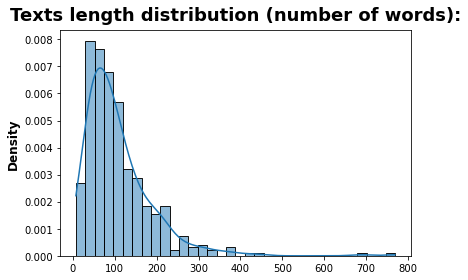

In [72]:
text_lenghts = [len(t.split()) for t in data["Sentence_Pristine"]]
ax = sns.histplot(data=text_lenghts, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words):")

In [73]:
max_length = 200

***
## 5.1 Loading BERT

In [74]:
model_name = "bert-base-uncased"

In [75]:
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

In [76]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)

In [77]:
transformer_model = TFBertModel.from_pretrained(pretrained_model_name_or_path=model_name, config=config)

2022-02-13 17:27:20.687136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:27:20.687918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:27:20.688395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:27:20.689239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:27:20.689592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

***
## 5.2 BERT Tokenizer

In [78]:
X = tokenizer(
    text=data["Sentence_Pristine"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

# y_tags = to_categorical(data["Tags_Reduced"])

test_x = tokenizer(
    text=data_test["Sentence_Pristine"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

# test_y_tags = to_categorical(data_test["Tags_Reduced"])

In [79]:
binarizer = MultiLabelBinarizer()

In [83]:
y_tags = binarizer.fit_transform(data["Tags_Reduced"])
test_y_tags = binarizer.transform(data_test["Tags_Reduced"])

In [84]:
y_tags[:2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]])

***
## 5.5 Tensorflow dataset creation

In [85]:
ds_train = tf.data.Dataset.from_tensor_slices((dict(X), y_tags))
ds_test = tf.data.Dataset.from_tensor_slices((dict(test_x), test_y_tags))

***
## 5.2 Network

https://keras.io/examples/nlp/multi_label_classification/

In [86]:
bert = transformer_model.layers[0]

In [87]:
input_ids = keras.layers.Input(shape=(max_length,), name="input_ids", dtype="int32")
inputs = {"input_ids": input_ids}

bert_model = bert(inputs)[0][:, 0, :]
dropout = keras.layers.Dropout(config.hidden_dropout_prob, name="pooled_output")
pooled_output = dropout(bert_model, training=False)

output = keras.layers.Dense(
    units=y_tags.shape[1],
    kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
    activation="sigmoid",
    name="output"
)(pooled_output)

model = Model(inputs=inputs, outputs=output, name='BERT_MultiLabel_MultiClass')

model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 200)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

In [88]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './bert_base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    restore_best_weights=True
)

optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

adam = Adam(5e-5)
loss = BinaryCrossentropy()
# loss = CategoricalCrossentropy(from_logits = True)
metric_accuracy = CategoricalAccuracy('accuracy')

model.compile(
    optimizer=adam,
    loss=loss,
    metrics=[
        # metric_accuracy,
        multi_label_accuracy,
        "binary_accuracy",
        AUC(name="average_precision", curve="PR", multi_label=True)
    ]
)

In [89]:
EPOCHS = 5

history = model.fit(
    ds_train.shuffle(1000).batch(4),
    validation_data=ds_test.batch(4),
    epochs=EPOCHS,
    batch_size=4,
    callbacks=[early_stopping_callback],
    workers=8,
    # validation_split=0.2
)

Epoch 1/5
109/109 [==============================] - 82s 633ms/step - loss: 0.2630 - multi_label_accuracy: 0.0000e+00 - binary_accuracy: 0.9645 - average_precision: 0.0286 - val_loss: 0.1480 - val_multi_label_accuracy: 0.0000e+00 - val_binary_accuracy: 0.9754 - val_average_precision: 0.0267
Epoch 2/5
101/109 [==========================>...] - ETA: 4s - loss: 0.1281 - multi_label_accuracy: 0.0000e+00 - binary_accuracy: 0.9754 - average_precision: 0.0255

***
## 5.3 Results

In [ ]:
benchmarks = model.evaluate(
    ds_test.batch(4),
    return_dict=True,
    batch_size=4
)

benchmarks

# evaluation["BERT_base"] = [
#     benchmarks[k] for k in 
#     ["multi_label_accuracy", "binary_accuracy", "loss", "average_precision"]
# ]
# evaluation

In [ ]:
history_bert = pd.DataFrame(data=history.history)
# visualize_history(history_bert, metrics="binary_accuracy")
for metric in ["multi_label_accuracy", "binary_accuracy", "average_precision"]:
    visualize_history(history_bert, metrics=metric)

***
# 6 Conclusion